<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="" 
               style="width:10px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;"><h2>02. Baseline whole population light gbm regressor</h2></div>

 <a id="top"></a> <br>
## Índice
1. [Entradas y Entregable](#1)<br>
    1.1. [Entradas del modelo](#11)<br>
    1.2. [Entregable](#12)<br>
2. [Carga de paquetes y datos](#2)<br>
    2.1. [Librerías y clases](#21)<br>
    2.2. [Lectura de datos](#22)<br>
    2.3. [Eliminación de valores nulos](#23)<br>
    2.4. [Separación en train y test](#24)<br>
3. [Modelo](#3)<br>
    3.1. [Confección pipeline](#31)<br>
    3.2. [Entrenamiento del modelo](#32)<br>
    3.3. [Evaluación del modelo](#33)<br>

***
<a id="1"></a> <br>
## 1. Entradas y Entregable

<a id="11"></a>
### 1.1. Entradas

|Tipo|Nombre|Descripción|Ubicación Lab|
|:-------|----------------|---------------------------------------------------|-------------------------------------|
|**csv**| `Dataset participantes.csv` | datos relacionados con los pozos al producirse una interferencia por la estimulación de un pozo hijo |`/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/`|

<a id="12"></a>
### 1.2. Entregable

**Archivo csv con las estimaciones de delta_WHP**

***
<a id="2"></a> <br>
## 2. Carga de paquetes y datos

<a id="21"></a>
### 2.1. Librerías y clases

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb

import chardet

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self  

In [ ]:
# Esta función grafica los residuos de las predicciones del modelo
def diag_residuos (y, X,model):

    # Diagnóstico errores (residuos) de las predicciones de entrenamiento
    # ==============================================================================
    prediccion = model.predict(X)
    residuos   = prediccion - y
    # Gráficos
    # ==============================================================================
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))

    axes[0, 0].scatter(y, prediccion, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()],'k--', color = 'black', lw=2)
    axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
    axes[0, 0].set_xlabel('Real')
    axes[0, 0].set_ylabel('Predicción')
    axes[0, 0].tick_params(labelsize = 7)

    axes[0, 1].scatter(list(range(len(y))), residuos, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[0, 1].set_xlabel('id')
    axes[0, 1].set_ylabel('Residuo')
    axes[0, 1].tick_params(labelsize = 7)

    sns.histplot( data = residuos, stat = "density", kde = True, line_kws= {'linewidth': 1}, color = "firebrick", alpha   = 0.3, ax = axes[1, 0])

    axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[1, 0].set_xlabel("Residuo")
    axes[1, 0].tick_params(labelsize = 7)


    sm.qqplot( residuos, fit = True, line  = 'q', ax = axes[1, 1], color = 'firebrick', alpha = 0.4, lw = 2 )

    axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[1, 1].tick_params(labelsize = 7)

    axes[2, 0].scatter(prediccion, residuos, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
    axes[2, 0].set_xlabel('Predicción')
    axes[2, 0].set_ylabel('Residuo')
    axes[2, 0].tick_params(labelsize = 7)

    # Se eliminan los axes vacíos
    fig.delaxes(axes[2,1])

    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

<a id="22"></a> <br>
### 2.2. Lectura de datos

In [ ]:
# Detección automática de la codificación de los caracteres
with open("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes (corregido).csv", 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large

# Lectura del csv
df = pd.read_csv("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes (corregido).csv",encoding = enc['encoding'], index_col=0)

df.sample(5)

,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
ID_FILA,,,,,,,,,,,,,,,,
22715,Pozo 161-Pozo 158-23,Campo D,OIL,PAD-53,Pozo 161,23,Pozo 158,345.053820,344.839845,12.149888,273.698779,1.0,NO,263.0,6.8,Cerrado
21468,Pozo 156-Pozo 154-5,Campo D,OIL,PAD-36,Pozo 156,5,Pozo 154,1399.945932,1399.944418,-2.058313,179.952992,0.0,NO,180.3,0.0,Cerrado
14298,Pozo 407-Pozo 245-21,Campo F,OIL,PAD-60,Pozo 407,21,Pozo 245,1394.934723,1394.808494,18.765547,265.841822,0.0,NO,265.7,0.0,Abierto
14167,Pozo 549-Pozo 393-7,Campo E,OIL,PAD-84,Pozo 549,7,Pozo 393,1008.775546,1008.361015,-28.916522,166.199822,0.0,NO,256.9,-0.5,Abierto
2704,Pozo 552-Pozo 295-11,Campo E,OIL,PAD-85,Pozo 552,11,Pozo 295,861.447489,860.249628,45.413158,172.317320,0.0,NO,30.8,0.0,Abierto


In [ ]:
delta_WHP = df[['delta_WHP']]

In [ ]:
y_pred_clas_zeros = delta_WHP.copy(deep=True)
y_pred_clas_zeros.loc[:]=0 

In [ ]:
y_pred_clas_zeros

,delta_WHP
ID_FILA,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
...,...
26174,0.0
26175,0.0
26176,0.0


In [ ]:
import math

In [ ]:
RMSE = math.sqrt(np.square(y_pred_clas_zeros).mean())

In [ ]:
df_concat = pd.concat([df,df_empty], axis = 0)

In [ ]:
df

,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
ID_FILA,,,,,,,,,,,,,,,,
1,Pozo 81-Pozo 22-37,Campo D,OIL,PAD-47,Pozo 81,37,Pozo 22,1323.623144,1323.212672,32.961374,199.623188,0.0,NO,-0.2,0.0,Abierto
2,Pozo 132-Pozo 112-10,Campo C,GAS,PAD-19,Pozo 132,10,Pozo 112,1184.248919,1184.233308,6.080755,345.025732,0.0,NO,-0.1,0.0,Abierto
3,Pozo 133-Pozo 112-21,Campo C,GAS,PAD-19,Pozo 133,21,Pozo 112,847.811857,847.771101,8.312941,342.171963,0.0,NO,-0.1,0.0,Abierto
4,Pozo 478-Pozo 122-6,Campo C,GAS,PAD-21,Pozo 478,6,Pozo 122,625.328398,625.314697,4.139460,259.131395,1.0,NO,-0.1,0.0,Abierto
5,Pozo 405-Pozo 242-19,Campo F,OIL,PAD-60,Pozo 405,19,Pozo 242,1118.214531,1118.074170,17.716903,90.993004,3.0,NO,-0.1,0.0,Abierto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26174,Pozo 295-Pozo 280-18,Campo F,OIL,PAD-65,Pozo 295,18,Pozo 280,326.163390,325.992246,10.564672,97.697204,0.0,SI,437.2,9.7,Cerrado
26175,Pozo 334-Pozo 280-17,Campo F,OIL,PAD-65,Pozo 334,17,Pozo 280,948.089650,948.087105,2.196724,94.998849,0.0,SI,444.1,0.0,Cerrado
26176,Pozo 295-Pozo 280-19,Campo F,OIL,PAD-65,Pozo 295,19,Pozo 280,327.487483,327.306179,10.895718,83.132275,0.0,SI,444.7,12.2,Cerrado


In [ ]:
df_campo=df.CAMPO.copy(deep=True)

In [ ]:
df_campo.loc[:]=0

In [ ]:
df_campo

ID_FILA
1        0
2        0
3        0
4        0
5        0
        ..
26174    0
26175    0
26176    0
26177    0
26178    0
Name: CAMPO, Length: 26178, dtype: object

In [ ]:
df_campo = df[['CAMPO']]
df_campo


,CAMPO
ID_FILA,
1,Campo D
2,Campo C
3,Campo C
4,Campo C
5,Campo F
...,...
26174,Campo F
26175,Campo F
26176,Campo F


In [ ]:
df_campo

,CAMPO
ID_FILA,
1,Campo D
2,Campo C
3,Campo C
4,Campo C
5,Campo F
...,...
26174,Campo F
26175,Campo F
26176,Campo F


In [ ]:
df_campo2 = df_campo.copy(deep=True)
df_campo2.loc[:]=0

In [ ]:
df_campo2

,CAMPO
ID_FILA,
1,0
2,0
3,0
4,0
5,0
...,...
26174,0
26175,0
26176,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Se cambia el tipo de datos de variables categóricas nominales de object a category
df = df.astype({"CAMPO": "category", "FLUIDO": "category", "PAD_HIJO": "category", "HIJO": "category",
                "ETAPA_HIJO": "category", "PADRE": "category", "LINEAMIENTO": "category", "ESTADO": "category"})
df.dtypes

ID_EVENTO        object
CAMPO          category
FLUIDO         category
PAD_HIJO       category
HIJO           category
ETAPA_HIJO     category
PADRE          category
D3D             float64
D2D             float64
DZ              float64
AZ              float64
#_BARRERAS      float64
LINEAMIENTO    category
WHP_i           float64
delta_WHP       float64
ESTADO         category
dtype: object

<a id="24"></a> <br>
### 2.4. Separación en train y test

In [ ]:
# Selección de variable target
y = df.delta_WHP
# Selección de features
X = df.drop(["delta_WHP"], axis = 1)

# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 161)

# Verificación de distribución de variable targuet en train y test
print("Instancias de train \n", X_train.shape[0])
print("Instancias de test \n", X_test.shape[0])

Instancias de train 
 19633
Instancias de test 
 6545


***
<a id="#3"></a> <br>
## 3. Modelo

<a id="31"></a> <br>
### 3.1. Confección pipeline

In [ ]:
# Instanciado de estimador
light_gbm = lgb.LGBMRegressor(random_state = 45)

# Instanciado de pipeline
pipe = Pipeline([ ("ColumnDropper", ColumnDropper(["ID_EVENTO"])),
                  
                  ("column_transformer",ColumnTransformer([
                                        ("standard_scaler", StandardScaler(), 
                    ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                 
                                 ("light_gbm", light_gbm)])

<a id="32"></a> <br>
### 3.2. Entrenamiento del modelo

In [ ]:
# Seteado de parámetros de entrenamiento
fit_params={"light_gbm__categorical_feature": "auto" }

# Entrenamiento del modelo
model = pipe.fit(X_train,y_train, **fit_params)

<a id="33"></a> <br>
### 3.3. Evaluación del modelo

In [ ]:
# Valor de RMSE en train
print("RMSE en train = ",mean_squared_error(y_train, model.predict(X_train), squared=False))
print("RMSE en test = ",mean_squared_error(y_test, model.predict(X_test), squared=False))

RMSE en train =  4.28554194027627
RMSE en test =  6.771072885993003


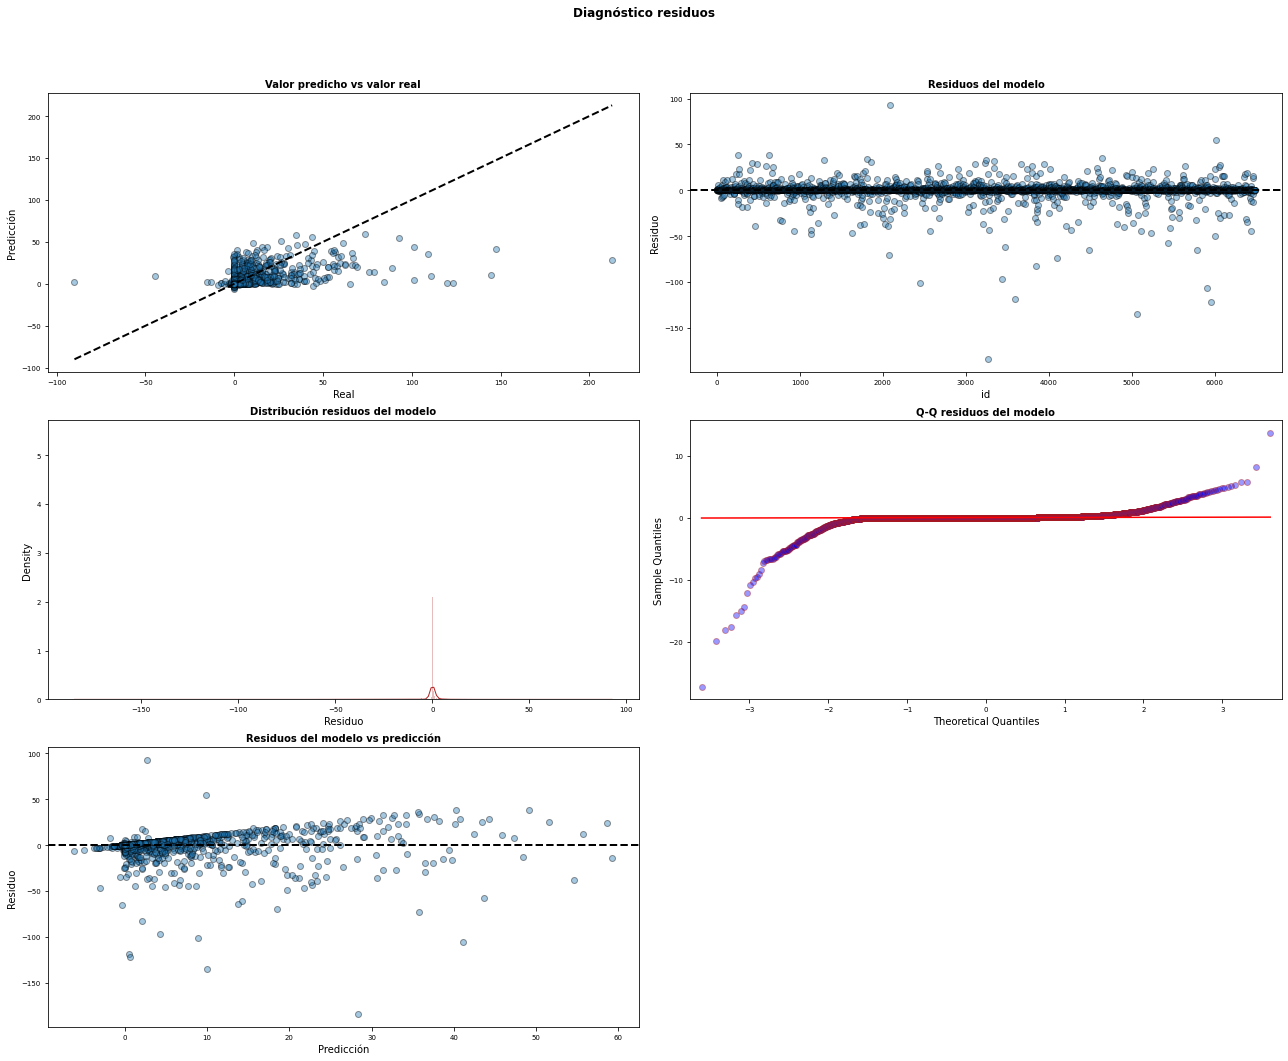

In [ ]:
# Evaluación de residuos
diag_residuos(y_test, X_test, model)